# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Sunday, June 16, 9pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Huan Ling

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://drive.google.com/open?id=1kD7607FqmyEuzbiiwaDXd03YQEIFxzQ4

In [1]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [4]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [5]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [6]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [7]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [8]:
num_sample = df.shape[0]

for col in ["age", "yredu", "capgain", "caploss", "workhr"]:
  col_max = np.amax(df[col])
  col_min = np.amin(df[col])
  col_ave = np.sum(df[col])/num_sample
  print("The maximum "+col+ " is: " + str(col_max))
  print("The minimum "+col+ " is: " + str(col_min))
  print("The average "+col+ " is: " + str(col_ave))
  df[col] = (df[col] - col_min)/(col_max - col_min)

The maximum age is: 90
The minimum age is: 17
The average age is: 38.58164675532078
The maximum yredu is: 16
The minimum yredu is: 1
The average yredu is: 10.0806793403151
The maximum capgain is: 99999
The minimum capgain is: 0
The average capgain is: 1077.6488437087312
The maximum caploss is: 4356
The minimum caploss is: 0
The average caploss is: 87.303829734959
The maximum workhr is: 99
The minimum workhr is: 1
The average workhr is: 40.437455852092995


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [9]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

21790

In [10]:
num_sample = df.shape[0]
male_percentage = sum(df["sex"] == " Male") / num_sample
female_percentage = sum(df["sex"] == " Female") / num_sample

print(str(male_percentage*100)+ "% of the people are male.")
print(str(female_percentage*100)+ "% of the people are female.")

66.92054912318419% of the people are male.
33.07945087681583% of the people are female.


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [11]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [12]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

num_with_missing = df_with_missing.shape[0]
removed_percentage = num_with_missing / df.shape[0]
print(str(num_with_missing) + " records contained missing features.")
print(str(removed_percentage*100)+ "% of records were removed")

1843 records contained missing features.
5.660145572924664% of records were removed


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
poss_val_work = set(df_not_missing["work"])
print(poss_val_work)

{' Without-pay', ' Self-emp-not-inc', ' Federal-gov', ' Local-gov', ' Self-emp-inc', ' Private', ' State-gov'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [13]:
data = pd.get_dummies(df_not_missing)

In [14]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [16]:
print("There are "+str(data.shape[1])+" columns in the dataframe data")

There are (30718, 57) columns in the dataframe data


The number is the second dimension of the data. 

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [17]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

print(data.keys())

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)


def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    return cat_values[feature][np.argmax(onehot)]

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)
np.random.shuffle(datanp)
train_split = int(len(datanp) * 0.7)
test_split = int(len(datanp) * 0.85)
train_data = datanp[:train_split] 
val_data = datanp[train_split:test_split]
test_data = datanp[test_split:]
print("There are "+str(len(train_data))+" items in training set.")
print("There are "+str(len(val_data))+" items in validation set.")
print("There are "+str(len(test_data))+" items in test set.")

There are 21502 items in training set.
There are 4608 items in validation set.
There are 4608 items in test set.


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        self.name = "large"
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 11)
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 24),
            nn.ReLU(),
            nn.Linear(24, 48),
            nn.ReLU(),
            nn.Linear(48, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

###The sigmoid activation makes it easier to compare the output with the acutal dataset. This is achieved through making the output have the same range as the actual dataset. All data in the dataset is either normalized to a value of 0 to 1 or has been encoded to a 0 or 1. A sigmoid gives us results in the same range (0 to 1). 

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_data, val_data, batch_size = 64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    ######################
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=1, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=1, shuffle = True)
    ######################
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    ######################
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    iters = []
    ######################
    for epoch in range(num_epochs):
      total_loss = 0.0
      i = 0 
      
      for data in train_loader:
        datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
        recon = model(datam)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        i += 1
      iters.append(epoch + 1)
      train_loss[epoch] = float(total_loss) / i
      val_loss[epoch] = get_loss(model, val_loader, criterion)
      train_acc[epoch] = get_accuracy(model, train_loader)
      val_acc[epoch] = get_accuracy(model, val_loader)
      print(("Epoch {}: Train acc: {}, Train loss: {} |" + "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1, train_acc[epoch], train_loss[epoch], val_acc[epoch], val_loss[epoch]))
      model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
      torch.save(model.state_dict(), model_path)
    
    ######################        
    #plotting 
    plt.title("Train vs. Validation Loss")
    plt.plot(iters, train_loss, label = "Train")
    plt.plot(iters, val_loss, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
  
    plt.title("Train vs. Validation Accuracy")
    plt.plot(iters, train_acc, label = "Train")
    plt.plot(iters, val_acc, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    val_max = np.amax(val_acc)
    max_idx = np.argmax(val_acc)
    print("Final Training Accuracy: {}" .format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1])) 
    print("Highest Validation Accuracy: {} at epoch {}".format(val_max, max_idx+1))

def get_loss(model, data_loader, criterion):
    i = 0
    total_loss = 0.0
    for data in data_loader:
      datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
      recon = model(datam)
      loss = criterion(recon, data)
      total_loss += loss.item()
      i += 1
    return float(total_loss) / i
  
def get_model_name(name, batch_size, learning_rate, epoch):

    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, 
                                                   learning_rate, epoch)
    return path

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

In [18]:
auto_encoder = AutoEncoder()
train(auto_encoder, train_data, val_data, batch_size = 64, num_epochs=30, learning_rate=0.0001)

NameError: ignored

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

###My tunning strategy is to tune one hyperparameter at a time and decide the optimal value for that hyperparameter by observing its effects on the training curve.
###I will focus on tuning the learning rate first because it has significant effects on validation loss compared to other hyperparameters such as batch size. With a large learning rate, the model is able to learn really fast but it also produces high validation loss. While a small learning rate allows the model to learn more accurately with a longer training time. However, it does not mean that the smaller the learning rate, the higher the validation accuracy. The optimal learning rate is the one that produces the highest validation accuracy while taking moderate time to train. My first goal is to find the optimal learning rate. My next step is to find the best batch_size based on the learning rate that I have chosen. Batch_size usually has a smaller offect on the validation accuracy. It is used to adjust the noise in the training curve and speed up the training process. The batch_size will be chosen based on the same criteria -- validation accuracy. 
###In the process of hyperparameter search, I will keep my num_eopch high all the time to make sure the model always overfit. Adjustments about num_epoch will be made at the end to avoid overfitting.

Epoch 1: Train acc: 0.4028850029454624, Train loss: 0.19725065323568525 |Validation acc: 0.4031394675925926, Validation loss: 0.08951112234758006
Epoch 2: Train acc: 0.45928285740861313, Train loss: 0.07387299449848277 |Validation acc: 0.4584056712962963, Validation loss: 0.0713129782428344
Epoch 3: Train acc: 0.45758534089852104, Train loss: 0.07093040762646567 |Validation acc: 0.4566695601851852, Validation loss: 0.07063446049061087
Epoch 4: Train acc: 0.45917434037143834, Train loss: 0.07038541375437662 |Validation acc: 0.45793547453703703, Validation loss: 0.07008666700373094
Epoch 5: Train acc: 0.46303444640808605, Train loss: 0.06973548947523038 |Validation acc: 0.4623480902777778, Validation loss: 0.06923585338518023
Epoch 6: Train acc: 0.4690183858865842, Train loss: 0.0677887378371365 |Validation acc: 0.46860532407407407, Validation loss: 0.06465894340847929
Epoch 7: Train acc: 0.5441974389979227, Train loss: 0.05930189309375627 |Validation acc: 0.5478153935185185, Validation 

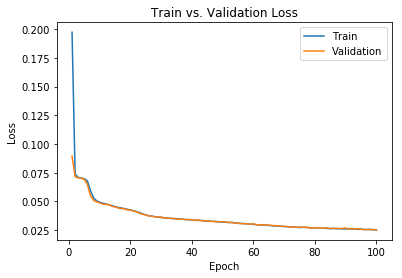

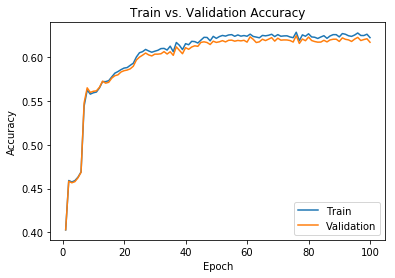

Final Training Accuracy: 0.6222754472452176
Final Validation Accuracy: 0.6170066550925926
Highest Validation Accuracy: 0.6245659722222222 at epoch 76


In [ ]:
#set1
#batch_size = 64, num_epochs=100, learning_rate=0.0001
#For the first set, I will first use a high num_epochs to make it overfit and 
#see how the model performs 
net1 = AutoEncoder()
train(net1, train_data, val_data, batch_size = 64, num_epochs=100, learning_rate=0.0001)

Epoch 1: Train acc: 0.596386382662078, Train loss: 0.05993588466108555 |Validation acc: 0.5955222800925926, Validation loss: 0.04090788624145918
Epoch 2: Train acc: 0.6075016277555576, Train loss: 0.03667531706326242 |Validation acc: 0.5998625578703703, Validation loss: 0.033226774979589715
Epoch 3: Train acc: 0.5988280159985118, Train loss: 0.030406505290773652 |Validation acc: 0.5917245370370371, Validation loss: 0.028935996944912605
Epoch 4: Train acc: 0.615989210306018, Train loss: 0.027242500285085822 |Validation acc: 0.6122685185185185, Validation loss: 0.026444516092952754
Epoch 5: Train acc: 0.6004247666883701, Train loss: 0.02508612493762658 |Validation acc: 0.5963179976851852, Validation loss: 0.025258328015398648
Epoch 6: Train acc: 0.6233063590983784, Train loss: 0.023641388372717693 |Validation acc: 0.6189959490740741, Validation loss: 0.023540260451328423
Epoch 7: Train acc: 0.6069900474374477, Train loss: 0.022573025029573944 |Validation acc: 0.6031901041666666, Validati

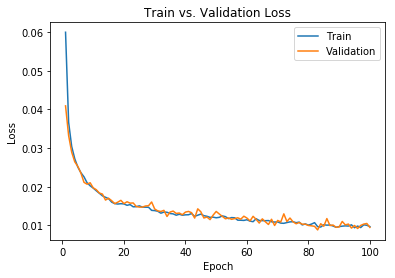

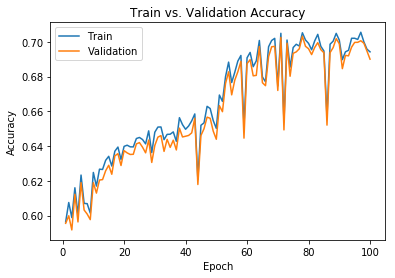

Final Training Accuracy: 0.6942377453260162
Final Validation Accuracy: 0.6900318287037037
Highest Validation Accuracy: 0.7032335069444444 at epoch 78


In [ ]:
#set2
#batch_size = 64, num_epochs=100, learning_rate=0.005
#It seems like the model learns really slow, and the validation accuracy does
#not increase much after 25 epochs. So I decided to use a large learning rate
#to speed up the training process. My other intention is to see whether a 
#smaller learning rate will produce a smaller validation loss. If that is true,
#I will keep decreasing the learning rate until the model does not perform any
#better or worse.
net2 = AutoEncoder()
train(net2, train_data, val_data, batch_size = 64, num_epochs=100, learning_rate=0.005)

Epoch 1: Train acc: 0.551375065885344, Train loss: 0.08664687695203438 |Validation acc: 0.5519024884259259, Validation loss: 0.05402179698770245
Epoch 2: Train acc: 0.5823411775648777, Train loss: 0.05111284673746143 |Validation acc: 0.5836226851851852, Validation loss: 0.04831734035784999
Epoch 3: Train acc: 0.5936889591665891, Train loss: 0.045585290961233635 |Validation acc: 0.5927010995370371, Validation loss: 0.04286252515804437
Epoch 4: Train acc: 0.5892785167271262, Train loss: 0.04141842667013407 |Validation acc: 0.5897352430555556, Validation loss: 0.04081788855708308
Epoch 5: Train acc: 0.6008588348370694, Train loss: 0.03950798068018187 |Validation acc: 0.6001519097222222, Validation loss: 0.038778145875160895
Epoch 6: Train acc: 0.6048042042600689, Train loss: 0.03792476784327023 |Validation acc: 0.6026114004629629, Validation loss: 0.03669203434967332
Epoch 7: Train acc: 0.6087573249000093, Train loss: 0.03563107986424473 |Validation acc: 0.6075665509259259, Validation los

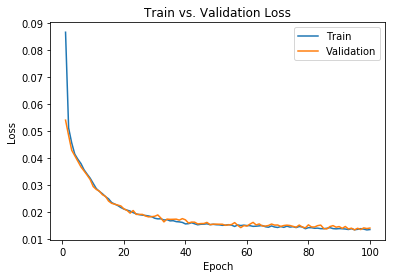

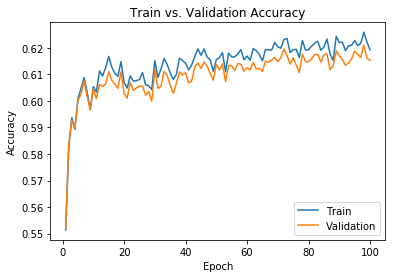

Final Training Accuracy: 0.6192059653365578
Final Validation Accuracy: 0.6153428819444444
Highest Validation Accuracy: 0.6209852430555556 at epoch 98


In [ ]:
#set3
#batch_size = 64, num_epochs=100, learning_rate=0.001
#The second outperforms the first model by having a high validtion accuracy.
#I will decrease the learning rate further more to see if it produces better
#results.
net3 = AutoEncoder()
train(net3, train_data, val_data, batch_size = 64, num_epochs=100, learning_rate=0.001)

Epoch 1: Train acc: 0.571218181254457, Train loss: 0.07338323056076963 |Validation acc: 0.5720124421296297, Validation loss: 0.0495339281236132
Epoch 2: Train acc: 0.6027346293368059, Train loss: 0.044427280380789726 |Validation acc: 0.5997178819444444, Validation loss: 0.04074860985080401
Epoch 3: Train acc: 0.6079589495550801, Train loss: 0.03687043297326281 |Validation acc: 0.6036964699074074, Validation loss: 0.035629335790872574
Epoch 4: Train acc: 0.6090828760115338, Train loss: 0.0317805431827548 |Validation acc: 0.6047815393518519, Validation loss: 0.0293847335399025
Epoch 5: Train acc: 0.6200430967661923, Train loss: 0.028039007880059735 |Validation acc: 0.6137152777777778, Validation loss: 0.026694697483132284
Epoch 6: Train acc: 0.6138498744302856, Train loss: 0.025688477470317765 |Validation acc: 0.6081090856481481, Validation loss: 0.02491614284614722
Epoch 7: Train acc: 0.6115942703004371, Train loss: 0.02445511731673919 |Validation acc: 0.6057581018518519, Validation los

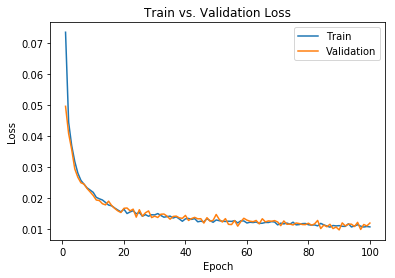

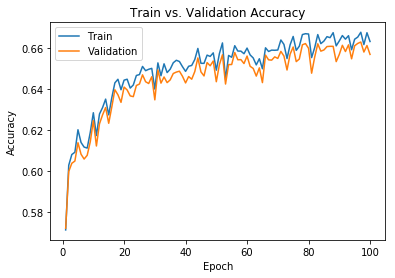

Final Training Accuracy: 0.6630468483551918
Final Validation Accuracy: 0.6567563657407407
Highest Validation Accuracy: 0.6627965856481481 at epoch 97


In [ ]:
#set4
#Based on the first 3 trials, 0.005 is the optimal learning rate.
#My next step is to tune the batch size.
#Base on the training curve in the second trial, there is some noise present 
#in the curve, so I decided to increase the batch size to reduce that and see
#if it would further improve the validation accuracy.
#batch_size = 128, num_epochs=100, learning_rate=0.005
net4 = AutoEncoder()
train(net4, train_data, val_data, batch_size = 128, num_epochs=100, learning_rate=0.005)

Epoch 1: Train acc: 0.5995256255232071, Train loss: 0.050526375230956114 |Validation acc: 0.59375, Validation loss: 0.0379242388298735
Epoch 2: Train acc: 0.6076876569621431, Train loss: 0.03255679774918549 |Validation acc: 0.6026475694444444, Validation loss: 0.028952258432077035
Epoch 3: Train acc: 0.6011766347316528, Train loss: 0.02613212776902531 |Validation acc: 0.5984157986111112, Validation loss: 0.023875515416471496
Epoch 4: Train acc: 0.6005720398102502, Train loss: 0.022681761344539978 |Validation acc: 0.5955222800925926, Validation loss: 0.021333471464458853
Epoch 5: Train acc: 0.6056568381235854, Train loss: 0.020620981340817662 |Validation acc: 0.6015263310185185, Validation loss: 0.020036771486047655
Epoch 6: Train acc: 0.6146017424735684, Train loss: 0.019420012101320373 |Validation acc: 0.6072771990740741, Validation loss: 0.019434206588711176
Epoch 7: Train acc: 0.6133227916782935, Train loss: 0.01876107280605495 |Validation acc: 0.6080005787037037, Validation loss: 0

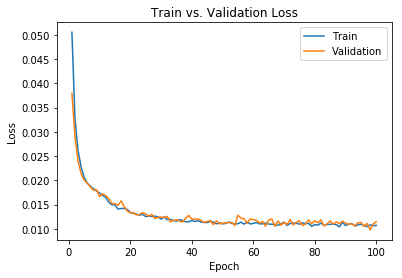

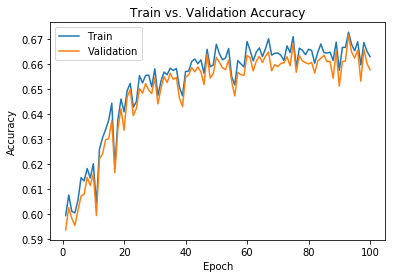

Final Training Accuracy: 0.6629848386196633
Final Validation Accuracy: 0.6576967592592593
Highest Validation Accuracy: 0.6716941550925926 at epoch 93


In [ ]:
#set5
#batch_size = 32, num_epochs=100, learning_rate=0.005
#It turned out that a larger batch size does not help improve the validation
#accuarcy for this model.
#So I will train this model with a smaller batch size to see what would
#happen. A small batch size might help the algorithm jump out of a local minimum.
net5 = AutoEncoder()
train(net5, train_data, val_data, batch_size = 32, num_epochs=100, learning_rate=0.005)

In [ ]:
#By either increasing or decreasing the batch size, the model's performance 
#is not improved.
#So I will keep the batch size at 64.

#It is time to pick the optimal num_epoch to prevent overfitting.
#I picked the model that has the highest validation accuracy and applied early 
#stopping to that model.
best = AutoEncoder()
model_path = get_model_name(best.name, batch_size=64, learning_rate=0.005, 
                            epoch=77)#actual epoch=90, num_epoch starts from 0
state = torch.load(model_path)
best.load_state_dict(state)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, num_workers=1, shuffle = True)
test_acc = get_accuracy(best, test_loader)
print("The test accuracy is "+str(test_acc))

The test accuracy is 0.7015335648148148


###The test accuracy (70.1%) is almost the same as the validation accuracy (70.3%) but a slightly lower, which is reasonable. Because the hyperparameters are tuned based on the validation set. 

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?

**Do not actually implement this baseline model. You should be able to compute the 
test accuracy by reasoning about how the basline model behaves.**

###Whenever asked to make a prediction, the baseline model will pick the most common value of the feature. Based on that, to get the test accuracy of the model, we just need to check the average number of the most common value for all features and the test accuracy should be close to that. 
###I will check the actual test accuracy by iterating through all the test data and comparing its each category value to the most common value of that feature. If the value matches, I increment the correct result by 1. The final test accuracy will be (#correct )/(#elements in the catcols in the test data).

In [ ]:
baseline_result = {}
for feature in catcols:
  start_index = cat_index[feature]
  stop_index = cat_index[feature] + len(cat_values[feature])
  records = train_data[:, start_index:stop_index]
  records_sum = np.sum(records, axis = 0)
  idx_max = np.argmax(records_sum)
  baseline_result[feature] = cat_values[feature][idx_max]
print(baseline_result)

#get accuaracy of the algorithm
total = 0
acc = 0
for col in catcols:
  for record in test_data: # test_data is the same in part1 g
    acc += int(baseline_result[col] == get_feature(record, col))
    total += 1
test_acc = acc / total
print("The total test accuracy is: {}".format(test_acc))

{'work': 'Private', 'marriage': 'Married-civ-spouse', 'occupation': 'Prof-specialty', 'edu': 'HS-grad', 'relationship': 'Husband', 'sex': 'Male'}
The total test accuracy is: 0.4568504050925926


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

###My test accuracy is part(a) is 25%higher than the baseline test accuracy in part(b). This high percentage difference is a evident indication that my autoencoder performs well.

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
first_features = {}
for col in catcols:
  first_features[col] = get_feature(test_data[0], col)
  
print(first_features)


{'work': 'Private', 'marriage': 'Divorced', 'occupation': 'Prof-specialty', 'edu': 'Bachelors', 'relationship': 'Not-in-family', 'sex': 'Male'}


###Note: I only displayed the first data's features in catcols, but other features not included in catcols are also helpful.

###Yes. I think it is reasonable to guess this person's education level based on his other features. Some of the closely related features to education are occupation, yredu and capgain. A person with higher capgain is more likely to have higher education level as he is more familiar and is aware of the importance of investing his wealth. Another clue for his education level is occupation. His occupation is Prof-specialty. People with high education level is more likely to have such occupation. Reasonable guesses based on these two clues are "Bachlors",  "Masters" or "PHD". 
###The most direct is the feature eduyr, we can basically tell a person's education level directly based on his eduyr unless this person has grade skipping or has taken any gap years.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


###I first created a copy of the first test data and zero out all the entries that belongs to "edu" category. 
###Then, I fed in the zeroed_feature data to my trained model and used get_feature function to obtain the prediction.

In [ ]:
sample = torch.tensor(test_data[0])
start_index = cat_index["edu"]
stop_index = cat_index["edu"] + len(cat_values["edu"])
sample[start_index:stop_index] = 0
out = best(sample).detach().numpy()
pred = get_feature(out, "edu")
print(pred)

Bachelors


###Given other features (work, marriage, occupation, relationship, sex) , my prediction is the same as the ground truth.

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
baseline_result["edu"]

'HS-grad'

###Same as part b, the base line model made predictions based on the most common value of the feature. 
###The most common value in "edu" category is "HS-grad", which does not match the actual value. This is actually a good indication that our model performs well on this particular problem. 